In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statsmodels
sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

#import pmdarima as pm


Wczytanie i podział danych

In [19]:
data = pd.read_csv(r"C:\Users\rafal\OneDrive\Dokumente\GitHub\Komputerowa-analiza-szeregow-czasowych\GlobalTemperatures2.csv")
data['dt'] = pd.to_datetime(data['dt']).dt.to_period('M').astype(str)
month = data['dt']
time = np.arange(0,len(month),1)
temperature = data['LandAverageTemperature'] 

Wizualizacja

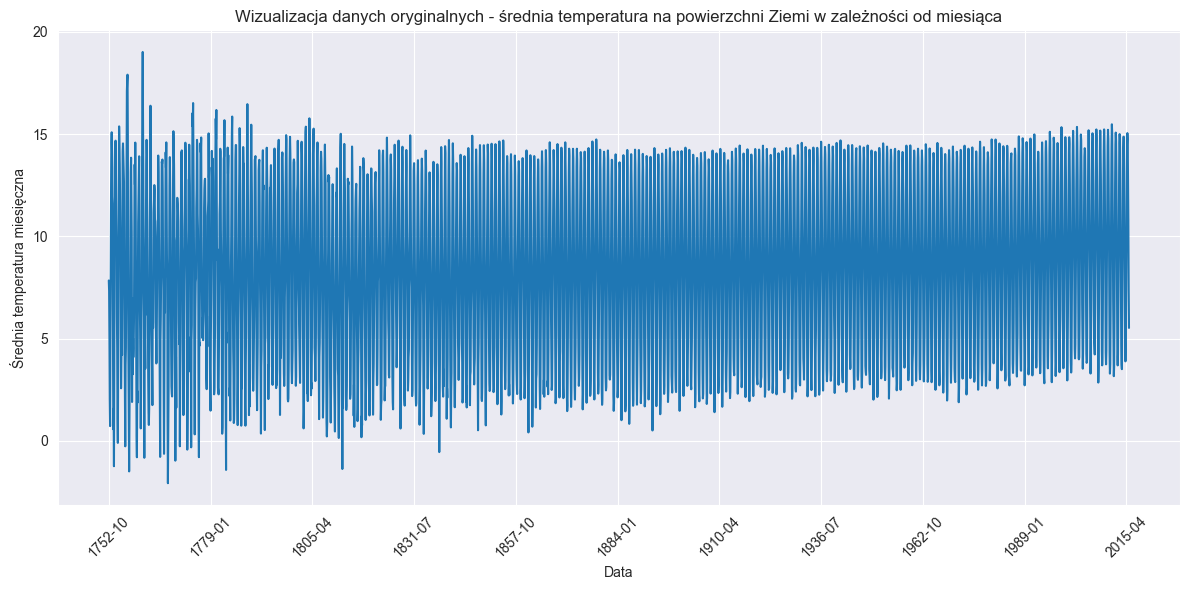

In [10]:
num_labels = 10  # Liczba etykiet, które mają być widoczne
indices = list(range(0, len(month), len(month) // num_labels))  # Indeksy równomiernie rozmieszczonych dat
selected_months = [month[i] for i in indices]  # Wybrane daty

plt.figure(figsize=(12, 6))
plt.plot(month, temperature)
plt.xticks(ticks=indices, labels=selected_months, rotation=45)  # Ustawienie etykiet osi X
plt.xlabel('Data')
plt.ylabel('Średnia temperatura miesięczna')
plt.title('Wizualizacja danych oryginalnych - średnia temperatura na powierzchni Ziemi w zależności od miesiąca')
plt.tight_layout()  # Zapewnienie lepszej estetyki wykresu
plt.show()


Sprawdzenie, czy są puste rekordy

In [7]:
data_info = data.info()
data_head = data.head()
data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3159 entries, 0 to 3158
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3159 non-null   object 
 1   LandAverageTemperature                     3159 non-null   float64
 2   LandAverageTemperatureUncertainty          3159 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 222.2+ KB


(None,
         dt  LandAverageTemperature  LandAverageTemperatureUncertainty  \
 0  1752-10                   7.839                              2.754   
 1  1752-11                   7.335                              2.747   
 2  1752-12                   5.086                              2.982   
 3  1753-01                   2.039                              3.478   
 4  1753-02                   0.715                              6.341   
 
    LandMaxTemperature  LandMaxTemperatureUncertainty  LandMinTemperature  \
 0                 NaN                            NaN                 NaN   
 1                 NaN                            NaN                 NaN   
 2                 NaN                            NaN                 NaN   
 3                 NaN                            NaN                 NaN   
 4                 NaN                            NaN                 NaN   
 
    LandMinTemperatureUncertainty  LandAndOceanAverageTemperature  \
 0            

Obserwacje odstające, statystyki opisowe dla zmiennej rainfalls

In [8]:
temperature_stats = data['LandAverageTemperature'].describe()
time_stats = data["dt"].describe()

Q1 = data['LandAverageTemperature'].quantile(0.25)
Q3 = data['LandAverageTemperature'].quantile(0.75)
IQR = Q3 - Q1
outlier_thresholds = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
outliers = data[(data['LandAverageTemperature'] < outlier_thresholds[0]) | 
                (data['LandAverageTemperature'] > outlier_thresholds[1])]

temperature_stats, time_stats, outliers

(count    3159.000000
 mean        8.377803
 std         4.378687
 min        -2.080000
 25%         4.318500
 50%         8.618000
 75%        12.548500
 max        19.021000
 Name: LandAverageTemperature, dtype: float64,
 count        3159
 unique       3159
 top       1752-10
 freq            1
 Name: dt, dtype: object,
 Empty DataFrame
 Columns: [dt, LandAverageTemperature, LandAverageTemperatureUncertainty, LandMaxTemperature, LandMaxTemperatureUncertainty, LandMinTemperature, LandMinTemperatureUncertainty, LandAndOceanAverageTemperature, LandAndOceanAverageTemperatureUncertainty]
 Index: [])

Sprawdzenie ciągłości miesięcy 

In [9]:
for i in range(1, len(month)):
    m_present = int(month[i][-2:])
    y_present = int(month[i][:4])
    m_previous = int(month[i-1][-2:])
    y_previous = int(month[i-1][:4])
    if m_present != m_previous + 1:
        if m_present == m_previous - 11:
            if y_present != y_previous + 1:
                print(f"Występuje brak ciągłości miesięcy między: {month[i-1]} a {month[i]}")
                break
        else:
            print(f"Występuje brak ciągłości miesięcy między: {month[i-1]} a {month[i]}")
            break
    if i == len(month)-1:
        print("W miesiącach nie brakuje danych, ciąłość jest zachowana")


W miesiącach nie brakuje danych, ciąłość jest zachowana


Przygotowanie zbioru testowego i treningowego

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train, test = train_test_split(temperature, test_size=0.2, shuffle=False)

ACF i PACF

In [5]:
h_max = 40

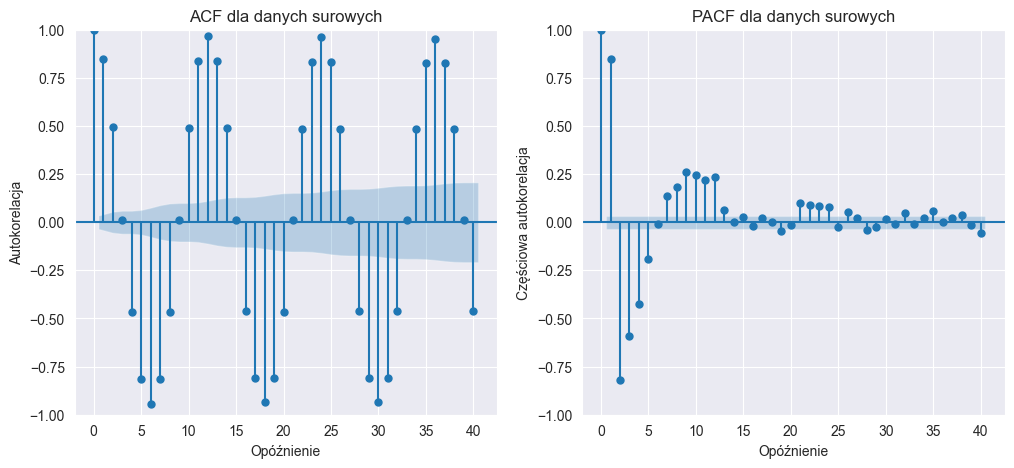

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plot_acf(temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych surowych')

plt.subplot(122)
plot_pacf(temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF dla danych surowych')

plt.show()

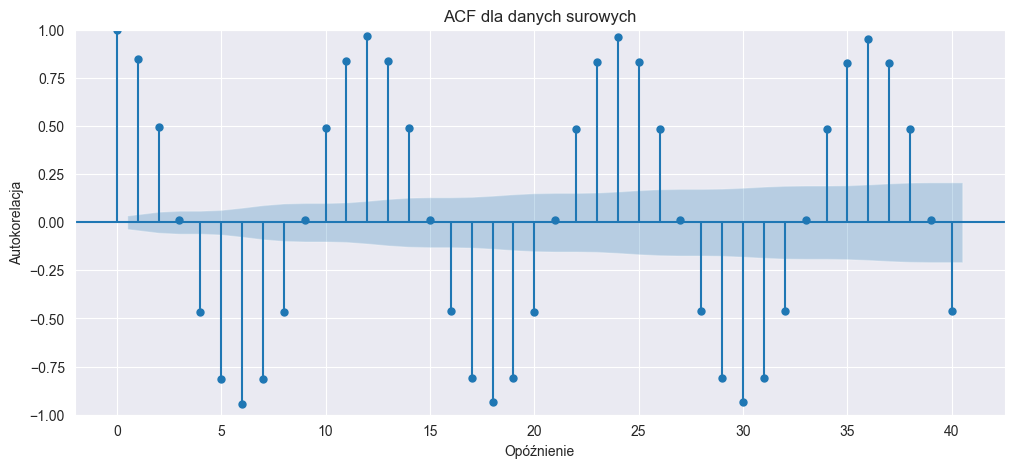

In [14]:
plt.figure(figsize=(12, 5))
plot_acf(temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych surowych')
plt.show()


Okres wynosi około 12

Test stacjonarności - Augmented Dickey-Fuller Test

In [15]:
def adfuller_test(series, sig = 0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

In [16]:
adfuller_test(temperature)AC

Statystyka testowa = -3.653, p-Value = 0.005 => Stationary. 


Dekompozycja

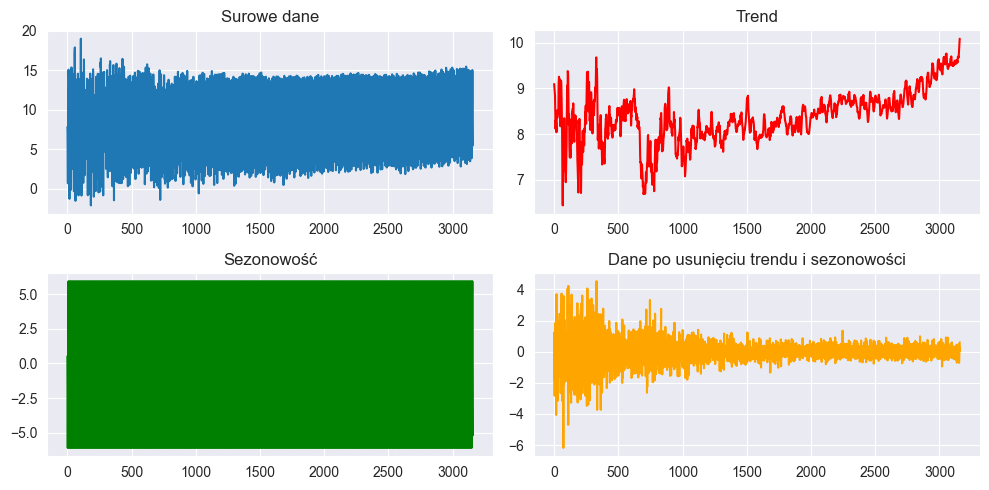

In [17]:
decomposition = seasonal_decompose(temperature, model='additive', period = 12, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(temperature, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

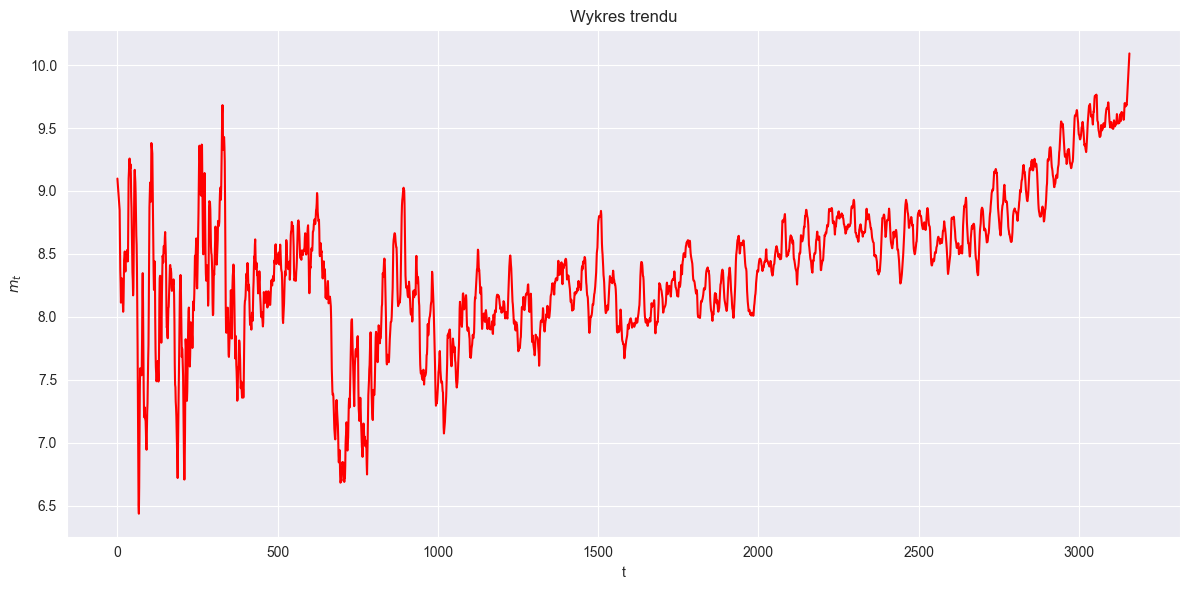

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(trend, label='Trend', color='red')
plt.xlabel("t")
plt.ylabel("$m_t$")
plt.title('Wykres trendu')
plt.tight_layout()
plt.show()

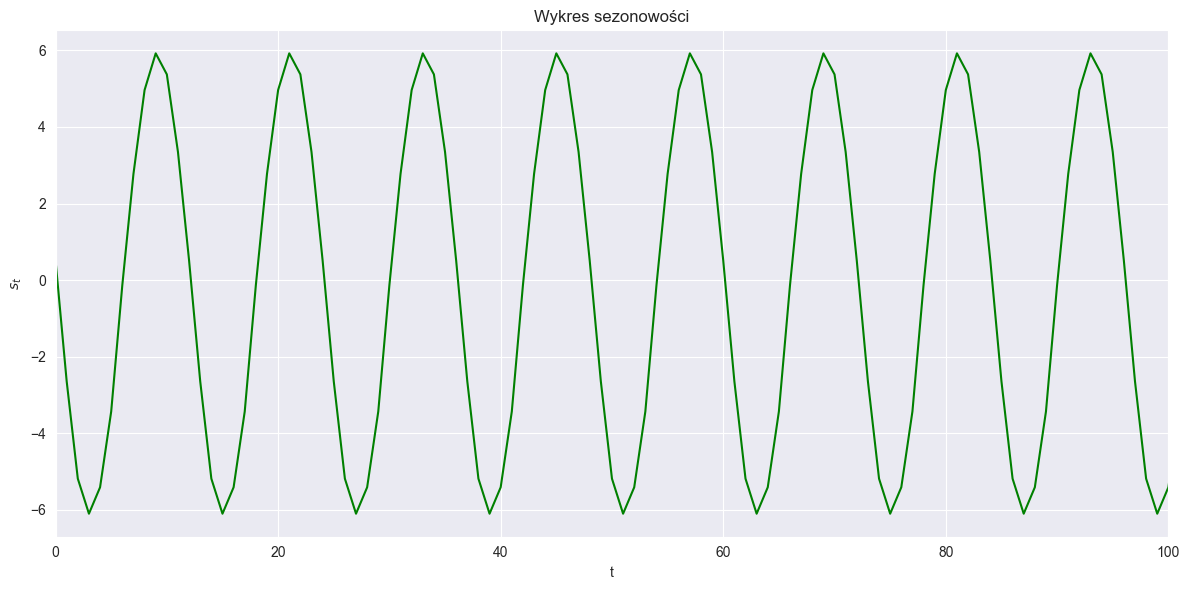

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(seasonal, label='Sezonowość', color='green')
plt.xlabel("t")
plt.xlim((0,100))
plt.ylabel("$s_t$")
plt.title('Wykres sezonowości')
plt.tight_layout()
plt.show()

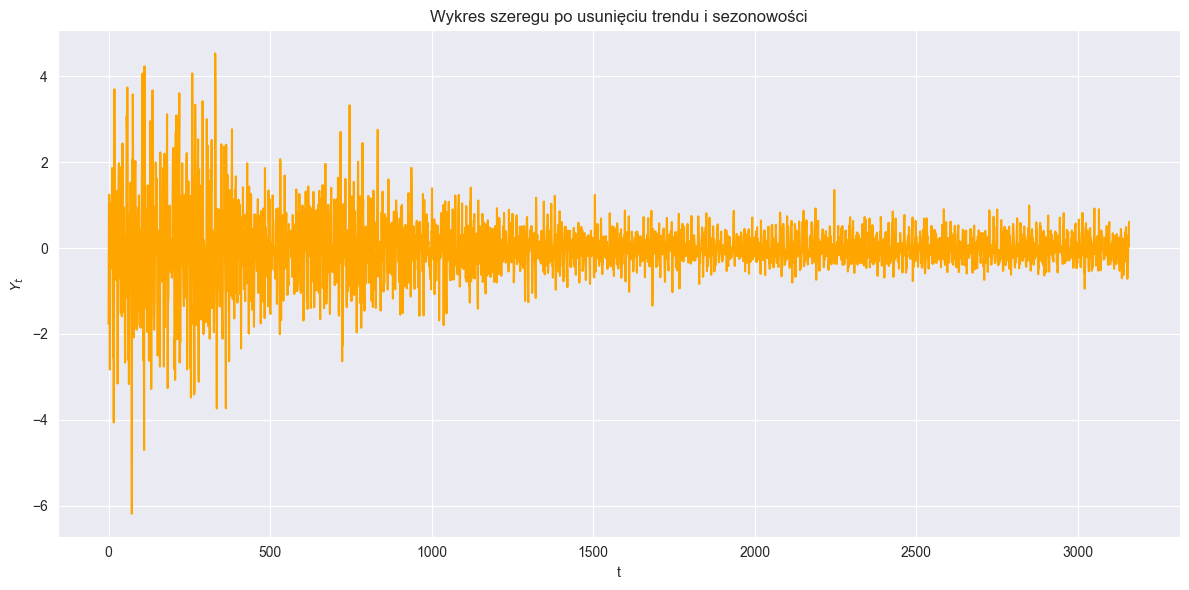

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(residual, label='Szum losowy', color='orange')
plt.xlabel("t")
plt.ylabel("$Y_t$")
plt.title('Wykres szeregu po usunięciu trendu i sezonowości')
plt.tight_layout()
plt.show()

In [20]:
nowa_temperature = list(temperature[1767:])
month = list(month[1767:])
len(month)

1392

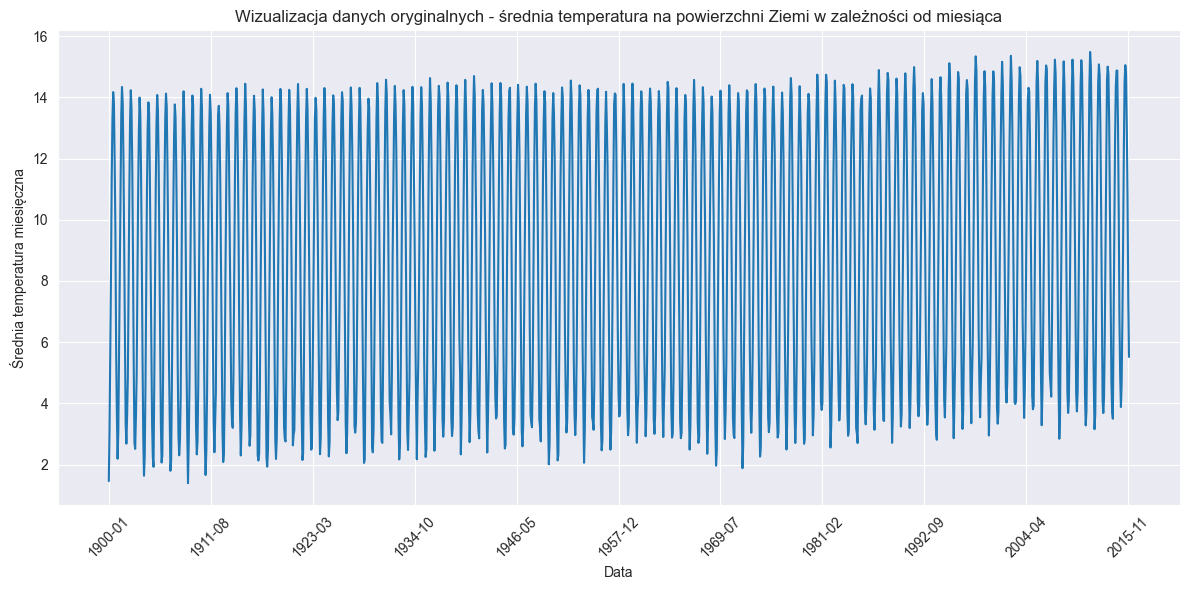

In [ ]:
num_labels = 10  # Liczba etykiet, które mają być widoczne
indices = list(range(0, len(month), len(month) // num_labels))  # Indeksy równomiernie rozmieszczonych dat
selected_months = [month[i] for i in indices]  # Wybrane daty
plt.figure(figsize=(12, 6))
plt.plot(month[:1392], nowa_temperature)
plt.xticks(ticks=indices, labels=selected_months, rotation=45)  # Ustawienie etykiet osi X
plt.xlabel('Data')
plt.ylabel('Średnia temperatura miesięczna')
plt.title('Wizualizacja danych obciętych - średnia temperatura na powierzchni Ziemi w zależności od miesiąca')
plt.tight_layout()  # Zapewnienie lepszej estetyki wykresu
plt.show()

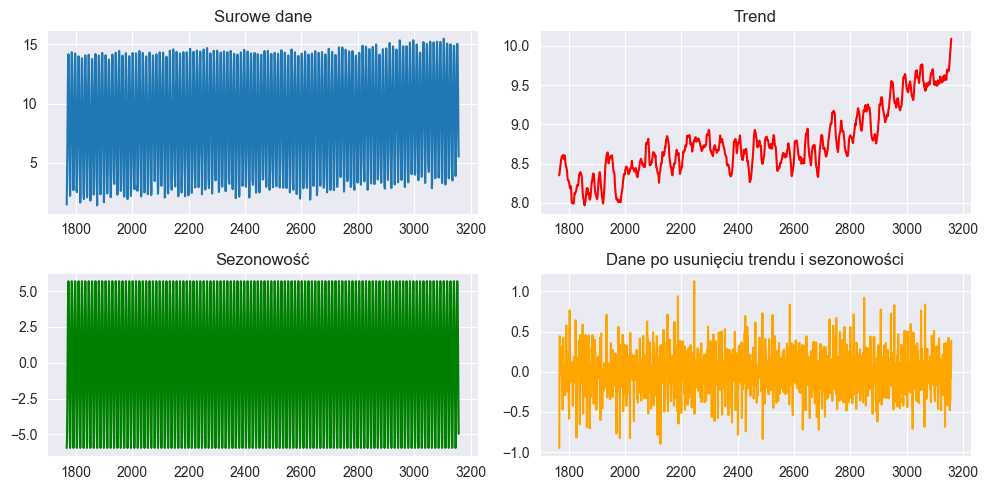

In [7]:
decomposition = seasonal_decompose(nowa_temperature, model='additive', period = 12, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(nowa_temperature, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

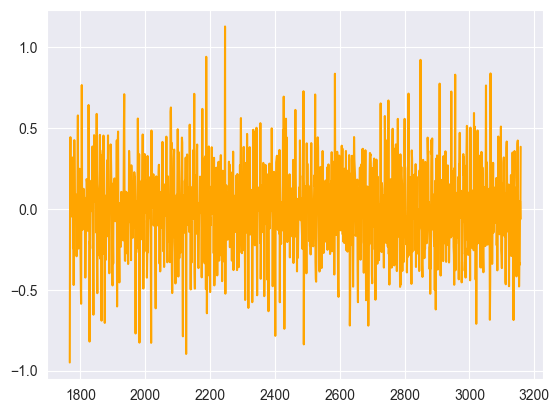

In [23]:
plt.plot(residual,color="orange")

In [24]:
mae_residual = np.mean(np.abs(nowa_temperature -residual))
print(f"Mean Absolute Error: {mae_residual}")

Mean Absolute Error: 8.762929178639848


In [25]:
temperature_clean = residual

In [26]:
train_clean, test_clean = train_test_split(temperature_clean, test_size=0.2, shuffle=False)

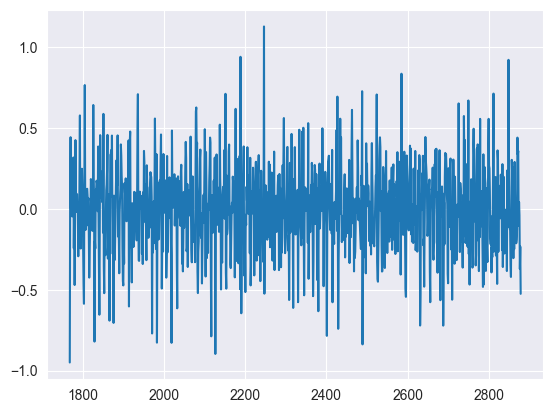

In [28]:
plt.plot(train_clean)

Sprawdzenie stacjonarności dla danych wyczyszczonych

In [29]:
adfuller_test(nowa_temperature)

Statystyka testowa = -0.691, p-value = 0.849 => Non-stationary.


In [30]:
adfuller_test(temperature_clean)

Statystyka testowa = -16.207, p-Value = 0.0 => Stationary. 


ACF i PACF dla wyczyszczonych danych

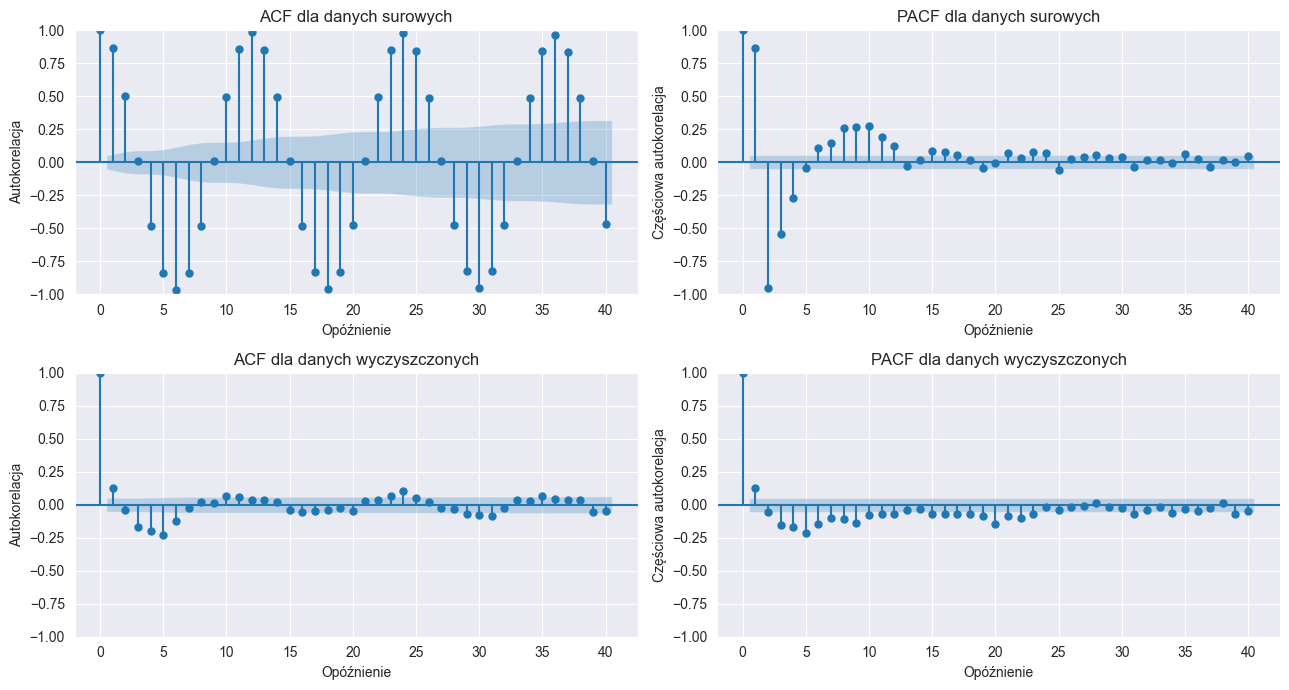

In [31]:
plt.figure(figsize=(13,7))

plt.subplot(223)
plot_acf(temperature_clean, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych wyczyszczonych')

plt.subplot(224)
plot_pacf(temperature_clean, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF dla danych wyczyszczonych')

plt.subplot(221)
plot_acf(nowa_temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych surowych')

plt.subplot(222)
plot_pacf(nowa_temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF dla danych surowych')

plt.tight_layout()
plt.show()

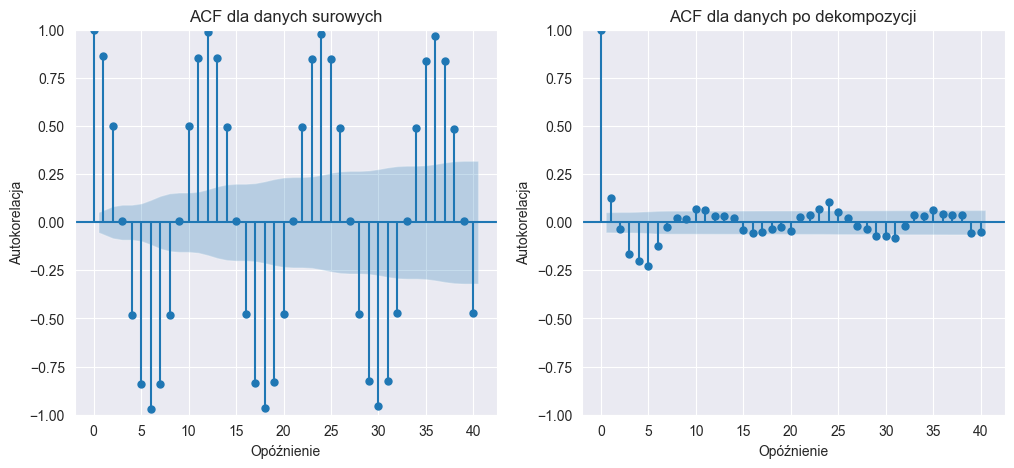

In [32]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plot_acf(nowa_temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych surowych')


plt.subplot(122)
plot_acf(temperature_clean, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych po dekompozycji')

plt.show()

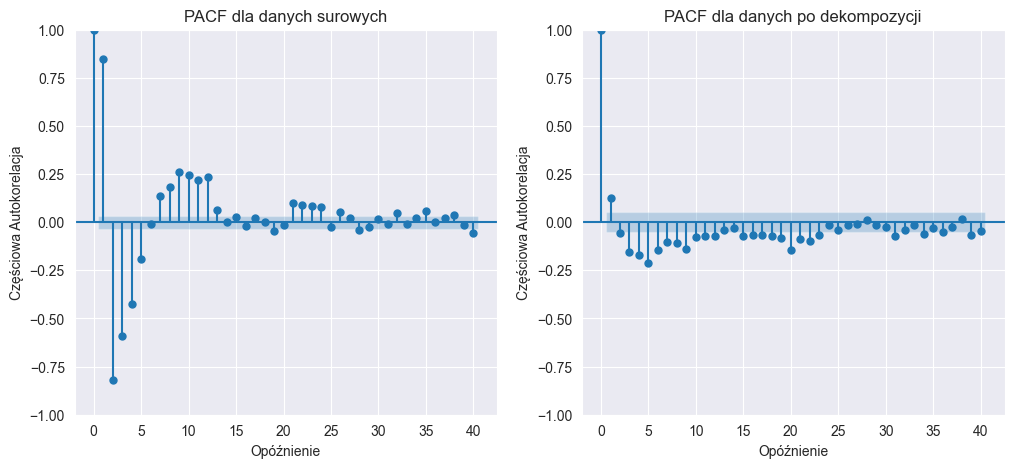

In [33]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plot_pacf(temperature, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa Autokorelacja')
plt.title('PACF dla danych surowych')


plt.subplot(122)
plot_pacf(temperature_clean, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa Autokorelacja')
plt.title('PACF dla danych po dekompozycji')

plt.show()

In [34]:
from scipy.stats import kstest, t, gamma

t_params = t.fit(temperature_clean)
df, loc, scale = t_params

ks_stat, p_value = kstest(temperature_clean, 't', args=(df, loc, scale))

print(f"Statystyka KS: {ks_stat:.4f}")
print(f"P-wartość KS testu: {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value > alpha:
    print("Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z t-rozkladu.")
else:
    print("Odrzucamy hipotezę zerową - reszty nie pasują do t-rozkladu.")

Statystyka KS: 0.0227
P-wartość KS testu: 0.4622
Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z t-rozkladu.


Dopasowanie modelu

In [44]:
df = pd.DataFrame()

ps = []
qs = []
BIC = []
AIC = []
HQIC = []

# Maksymalne wartości p i q
max_p = 10
max_q = 10

# Iteracja po możliwych wartościach p i q
for p in range(0, max_p):
    for q in range(0, max_q):
        
        # Dopasowanie modelu ARMA dla danego p i q
        model = ARIMA(train_clean, order=(p, 0, q))
        model_fit = model.fit()
        
        # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/

In [45]:
df.sort_values(by='AIC')

,p,q,AIC,BIC,HQIC
34,3,4,-106.277133,-61.143804,-89.212696
41,4,1,-104.972545,-69.868845,-91.700206
51,5,1,-103.250573,-63.132059,-88.082185
92,9,2,-102.028515,-36.835929,-77.379885
63,6,3,-101.501885,-46.338927,-80.645352
...,...,...,...,...,...
1,0,1,190.553920,205.598363,196.242065
10,1,0,192.062188,207.106631,197.750333
2,0,2,192.366901,212.426159,199.951095
11,1,1,192.498302,212.557559,200.082496


In [46]:
df.sort_values(by='BIC')

,p,q,AIC,BIC,HQIC
41,4,1,-104.972545,-69.868845,-91.700206
31,3,1,-96.389552,-66.300666,-85.013261
51,5,1,-103.250573,-63.132059,-88.082185
34,3,4,-106.277133,-61.143804,-89.212696
61,6,1,-98.810848,-53.677518,-81.746411
...,...,...,...,...,...
10,1,0,192.062188,207.106631,197.750333
20,2,0,189.660988,209.720246,197.245182
2,0,2,192.366901,212.426159,199.951095
11,1,1,192.498302,212.557559,200.082496


In [47]:
df.sort_values(by='HQIC')

,p,q,AIC,BIC,HQIC
41,4,1,-104.972545,-69.868845,-91.700206
34,3,4,-106.277133,-61.143804,-89.212696
51,5,1,-103.250573,-63.132059,-88.082185
31,3,1,-96.389552,-66.300666,-85.013261
61,6,1,-98.810848,-53.677518,-81.746411
...,...,...,...,...,...
20,2,0,189.660988,209.720246,197.245182
10,1,0,192.062188,207.106631,197.750333
2,0,2,192.366901,212.426159,199.951095
11,1,1,192.498302,212.557559,200.082496


In [48]:
model1 = pm.auto_arima(train_clean, 
                       d=0,
                       start_p=0,
                       start_q=0,
                       max_d=0,
                       max_p=7, 
                       max_q=7, 
                       max_order=None,
                       trace=True, 
                       seasonal=False, 
                       stepwise = False)

print(model1.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=207.838, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=188.559, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=190.371, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=1.24 sec
 ARIMA(0,0,6)(0,0,0)[0]             : AIC=inf, Time=1.88 sec
 ARIMA(0,0,7)(0,0,0)[0]             : AIC=inf, Time=2.49 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=190.067, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=190.503, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.68 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.89 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=inf, Time=1.50 sec
 ARIMA(1,0,6)(0,0,0)[0]             : AIC=inf, Time=2.09 sec
 ARIMA(1,0,7)(0,0,0)[0]             : AIC=-112.330, Time=2.76 sec

Estymacja parametrów

In [49]:
best_aic = np.inf
best_order = None
best_model = None
for p in range(5):
    for q in range(5):
        print(p,q)
        try:
            # Fit the ARMA(p, q) model
            model = pm.ARIMA(order=(p, 0, q), seasonal=False, suppress_warnings=True)
            model.fit(train_clean)

            # Check if this model is better (lower AIC)
            if model.aic() < best_aic:
                best_aic = model.aic()
                best_order = (p, q)
                best_model = model
        except Exception as e:
            # Handle cases where the model fails to converge
            print(f"Model ARMA({p}, {q}) failed: {e}")

# Print the best model results
if best_model:
    print(f"Best model order: ARMA{best_order} with AIC = {best_aic}")
else:
    print("No valid model found.")

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4
Best model order: ARMA(4, 1) with AIC = -92.1747493585736


In [57]:
p, q = 4,1

model41 = ARIMA(train_clean, order=(p, 0, q)).fit(method='innovations_mle')

print("Wyniki:")
print(model41.summary())
params41 = model41.params
print(params41)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Wyniki:
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                 1113
Model:                 ARIMA(4, 0, 1)   Log Likelihood                  61.400
Date:                Thu, 30 Jan 2025   AIC                           -108.799
Time:                        20:48:07   BIC                            -73.696
Sample:                             0   HQIC                           -95.527
                               - 1113                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.153e-06   4.73e-05      0.024      0.981   -9.16e-05    9.39e-05
ar.L1          0.8736      0.028     30.674      0.000       0.818       0.929
ar.L2         -0.1545      0.038     -4.033 

In [38]:
import statsmodels.tsa.statespace.sarimax as sss
modell = sss.SARIMAX(train_clean, order=(4, 0, 1)).fit()

# Now test for heteroskedasticity
het_test = modell.test_heteroskedasticity(method='breakvar',alternative='two-sided')
print(het_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.42136D-02    |proj g|=  5.74587D-02

At iterate    5    f=  1.67546D-02    |proj g|=  1.59277D-01

At iterate   10    f= -8.53444D-03    |proj g|=  5.20676D-02

At iterate   15    f= -2.81321D-02    |proj g|=  1.03887D-01

At iterate   20    f= -5.26424D-02    |proj g|=  5.44902D-02

At iterate   25    f= -5.48827D-02    |proj g|=  6.48564D-03

At iterate   30    f= -5.51428D-02    |proj g|=  1.10616D-03

At iterate   35    f= -5.51690D-02    |proj g|=  6.98377D-04

At iterate   40    f= -5.51725D-02    |proj g|=  2.68324D-04

At iterate   45    f= -5.51731D-02    |proj g|=  8.53747D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [58]:
const = params41[0]
ars = np.r_[1, -np.array(params41[1:p+1])]
mas = np.r_[1, np.array(params41[p+1:p+q+1])]
sigma2 = params41[-1]

M = 5000
n = len(train_clean)
lags = 50
acfs = np.zeros((M,lags+1))
pacfs = np.zeros((M,lags+1))
all_series = np.zeros((M, n))
dopasowany_ar_process = ArmaProcess(ar=ars,ma=mas)
for i in range(M):
    e = np.random.normal(0, np.sqrt(sigma2), n)
    nowe_simulated_data = dopasowany_ar_process.generate_sample(nsample=n, scale = np.sqrt(sigma2))

    all_series[i, :] = nowe_simulated_data
    acfs[i, :] = acf(nowe_simulated_data, nlags=lags, fft=True)
    pacfs[i, :] = pacf(nowe_simulated_data, nlags=lags, method='ywm')

qacf177 = np.zeros(lags + 1)
qacf277 = np.zeros(lags + 1)
qpacf177 = np.zeros(lags + 1)
qpacf277 = np.zeros(lags + 1)

for i in range(lags+1):
    qacf177[i] = np.quantile(acfs[:,i], 0.05)
    qacf277[i] = np.quantile(acfs[:,i], 0.95)
    qpacf177[i] = np.quantile(pacfs[:,i], 0.05)
    qpacf277[i] = np.quantile(pacfs[:,i], 0.95)

qseries00577 = np.zeros(n)
qseries02577 = np.zeros(n)
qseries0577 = np.zeros(n)
qseries07577 = np.zeros(n)
qseries09577 = np.zeros(n)

for i in range(n):
    qseries00577[i] = np.quantile(all_series[:,i], 0.05)
    qseries02577[i] = np.quantile(all_series[:,i], 0.25)
    qseries0577[i] = np.quantile(all_series[:,i], 0.5)
    qseries07577[i] = np.quantile(all_series[:,i], 0.75)
    qseries09577[i] = np.quantile(all_series[:,i], 0.95)

/var/folders/hn/gx3zxz4516s7kxrlbtw0ygmh0000gp/T/ipykernel_2121/2220572513.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  const = params41[0]
/var/folders/hn/gx3zxz4516s7kxrlbtw0ygmh0000gp/T/ipykernel_2121/2220572513.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma2 = params41[-1]


51


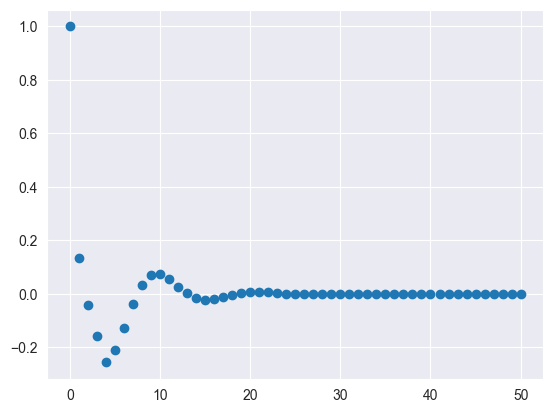

In [59]:
hs = np.linspace(0,50,51)
phi41 = np.array(ars)  # AR coefficients (including the leading 1)
theta41 = np.array(mas)  # MA coefficients (including the leading 1)
sigma41 =  0.0521 # Variance of the white noise

# Create an ARMA process using statsmodels
arma_process41 = ArmaProcess(ar=phi41, ma=theta41, nobs=1000)

# Compute theoretical ACF
acf_values41 = arma_process41.acf(lags=51)
acf_values_41 = arma_process41.acf(lags=100)
print(len(acf_values41))
# Compute PACF
pacf_values = pacf(acf_values_41, nlags=50, method='ols')


plt.scatter(hs,acf_values41)
plt.show()

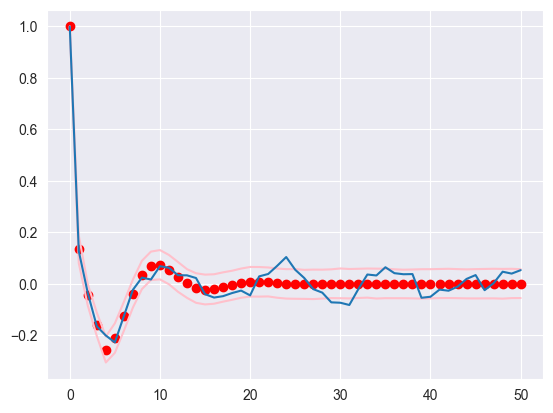

In [60]:
hs = np.linspace(0,50,51)
plt.plot(qacf177,color="pink")
plt.plot(qacf277,color="pink")
plt.plot(hs,acf(temperature_clean, nlags=lags, fft=True))
plt.scatter(hs,acf_values41,color="red")
plt.show()

Text(0.5, 1.0, 'ARMA(4,1)')

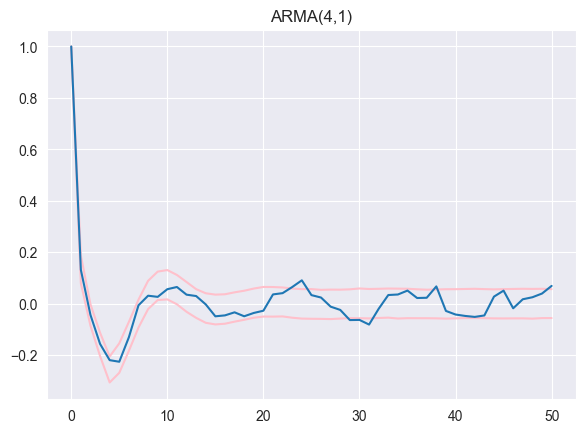

In [61]:
plt.figure().set_figwidth(15)
plt.subplot(1,2,1)
plt.plot(qacf177,color="pink")
plt.plot(qacf277,color="pink")
plt.plot(hs,acf(train_clean, nlags=lags, fft=True))
plt.title('ARMA(4,1)')

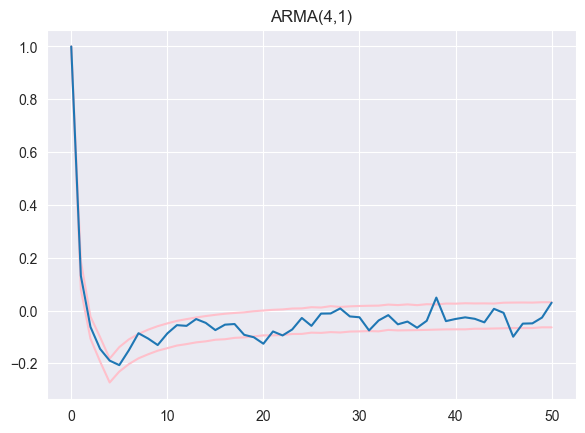

In [65]:
plt.figure().set_figwidth(15)
plt.subplot(1,2,1)
plt.plot(qpacf177,color="pink")
plt.plot(qpacf277,color="pink")
plt.plot(hs,pacf(train_clean, nlags=lags, method='ywm'))
plt.title('ARMA(4,1)')
plt.show()


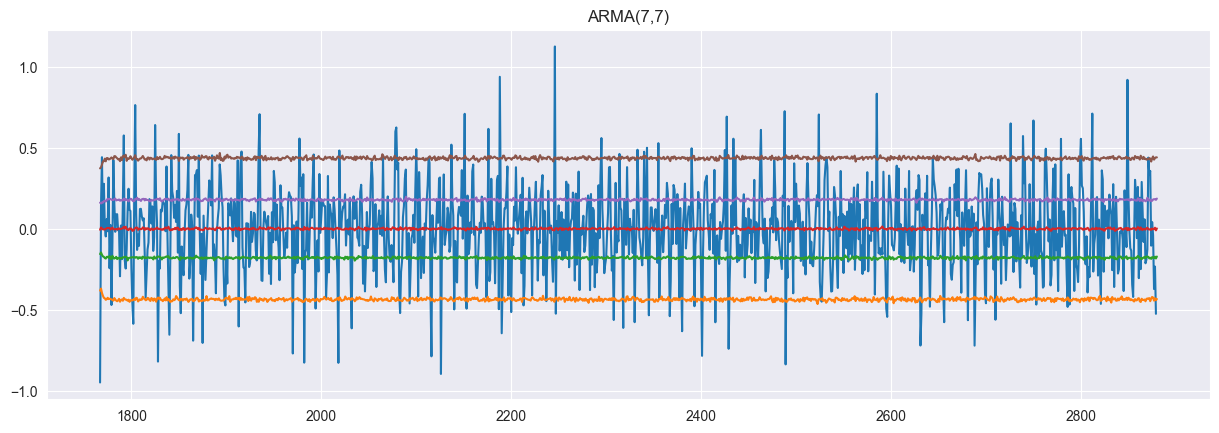

In [64]:
ns = np.linspace(len(temperature)-len(nowa_temperature),len(temperature)-len(test_clean),len(train_clean))
plt.figure().set_figwidth(15)
plt.plot(train_clean)
plt.plot(ns,qseries00577)
plt.plot(ns,qseries02577)
plt.plot(ns,qseries0577)
plt.plot(ns,qseries07577)
plt.plot(ns,qseries09577)
plt.title('ARMA(7,7)')
plt.show()

In [70]:
p, q = 4,1

model = ARIMA(train_clean, order=(p, 0, q)).fit()

params = model.params

const = params[0]
ars = np.r_[1, -np.array(params[1:p+1])]
mas = np.r_[1, np.array(params[p+1:p+q+1])]
sigma2 = params[-1]

M = 5000
n = len(train_clean)
lags = 50
all_series = np.zeros((M, n))
dopasowany_ar_process = ArmaProcess(ar=ars,ma=mas)
for i in range(M):
    e = np.random.normal(0, np.sqrt(sigma2), n)
    nowe_simulated_data = dopasowany_ar_process.generate_sample(nsample=n, scale = np.sqrt(sigma2))

    all_series[i, :] = nowe_simulated_data


qseries01 = np.zeros(n)
qseries02 = np.zeros(n)
qseries03 = np.zeros(n)
qseries04 = np.zeros(n)
qseries05 = np.zeros(n)
qseries06 = np.zeros(n)
qseries07 = np.zeros(n)
qseries08 = np.zeros(n)
qseries09 = np.zeros(n)

for i in range(n):
    qseries01[i] = np.quantile(all_series[:,i], 0.1)
    qseries02[i] = np.quantile(all_series[:,i], 0.2)
    qseries03[i] = np.quantile(all_series[:,i], 0.3)
    qseries04[i] = np.quantile(all_series[:,i], 0.4)
    qseries05[i] = np.quantile(all_series[:,i], 0.5)
    qseries06[i] = np.quantile(all_series[:,i], 0.6)
    qseries07[i] = np.quantile(all_series[:,i], 0.7)
    qseries08[i] = np.quantile(all_series[:,i], 0.8)
    qseries09[i] = np.quantile(all_series[:,i], 0.9)

licznik_0=0
licznik_1=0
licznik_2=0
licznik_3=0
licznik_4=0
licznik_5=0
licznik_6=0
licznik_7=0
licznik_8=0
licznik_9=0
for ns in range(n):
    print(ns+1767)
    probkowy_punkt = train_clean[ns+1767]
    if probkowy_punkt <= qseries01[ns]:
        licznik_0+= 1
    elif qseries01[ns] < probkowy_punkt <= qseries02[ns]:
        licznik_1+= 1
    elif qseries02[ns] < probkowy_punkt <= qseries03[ns]:
        licznik_2 += 1
    elif qseries03[ns] < probkowy_punkt <= qseries04[ns]:
        licznik_3 += 1
    elif qseries04[ns] < probkowy_punkt <= qseries05[ns]:
        licznik_4 += 1
    elif qseries05[ns] < probkowy_punkt <= qseries06[ns]:
        licznik_5 += 1
    elif qseries06[ns] < probkowy_punkt <= qseries07[ns]:
        licznik_6 += 1
    elif qseries07[ns] < probkowy_punkt <= qseries08[ns]:
        licznik_7 += 1
    elif qseries08[ns] < probkowy_punkt <= qseries09[ns]:
        licznik_8 += 1
    elif qseries09[ns] < probkowy_punkt:
        licznik_9 += 1
liczniki=[100*licznik_0/n,100*licznik_1/n,100*licznik_2/n,100*licznik_3/n,100*licznik_4/n,100*licznik_5/n,100*licznik_6/n,100*licznik_7/n,100*licznik_8/n,100*licznik_9/n]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/

1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966


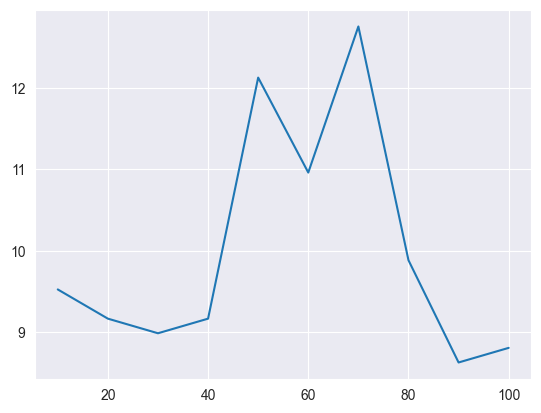

In [71]:
quant_s = np.linspace(10,100,10)
plt.plot(quant_s,liczniki)
plt.show()

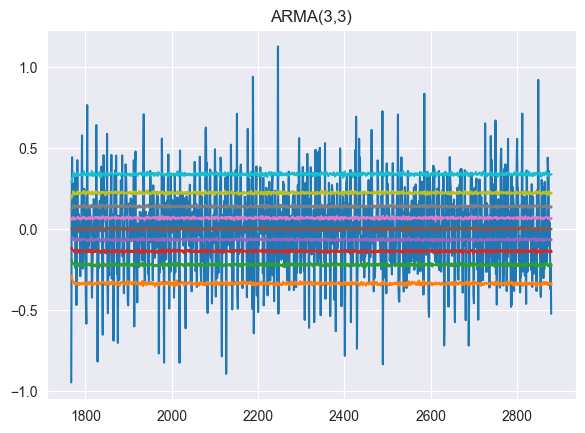

In [72]:
ns = np.linspace(len(temperature)-len(nowa_temperature),len(temperature)-len(test_clean),len(train_clean))
plt.figure().set_figwidth(15)
plt.subplot(1,2,1)
plt.plot(train_clean)
plt.plot(ns,qseries01)
plt.plot(ns,qseries02)
plt.plot(ns,qseries03)
plt.plot(ns,qseries04)
plt.plot(ns,qseries05)
plt.plot(ns,qseries06)
plt.plot(ns,qseries07)
plt.plot(ns,qseries08)
plt.plot(ns,qseries09)
plt.title('ARMA(3,3)')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/

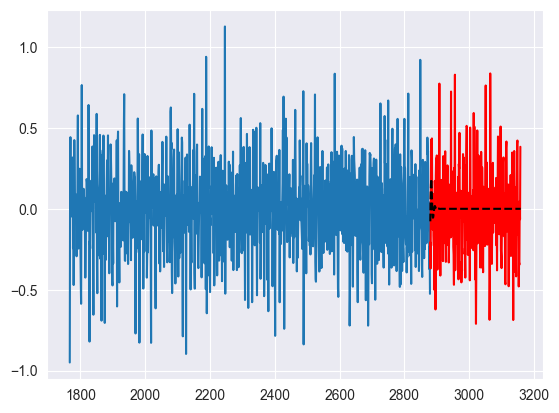

nan


In [40]:
p, q = 4,1
prognoza = ARIMA(train_clean, order=(p, 0, q)).fit(method='innovations_mle')
forecast1 = prognoza.forecast(steps=len(test_clean))
plt.plot(train_clean)
plt.plot(test_clean,color="red")
plt.plot(np.linspace(len(temperature)-len(test_clean),len(temperature),len(test_clean)),forecast1, label='Forecast', linestyle='--',color="black")
plt.show()
print(np.mean(test_clean-forecast1))

In [99]:
fitted_values = list(prognoza.predict())
fitted_values.extend(list(forecast1))
ostateczny = fitted_values + trend + seasonal

In [102]:
print(len(train_clean))

1113


In [109]:
treningowe,testowe = list(nowa_temperature)[:1113],list(nowa_temperature)[1113:]

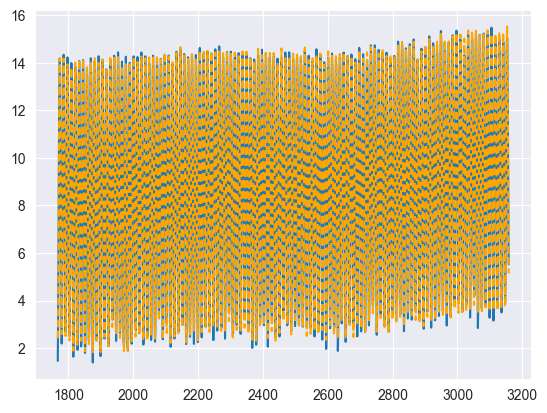

In [101]:
plt.plot(nowa_temperature)
plt.plot(ostateczny,color="orange",linestyle="--")


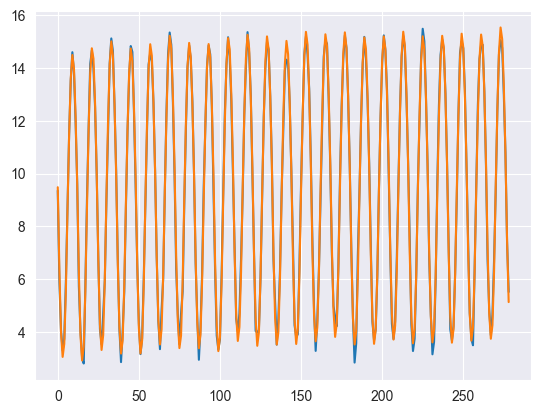

In [117]:
plt.plot(testowe)
plt.plot(list(ostateczny)[1113:])

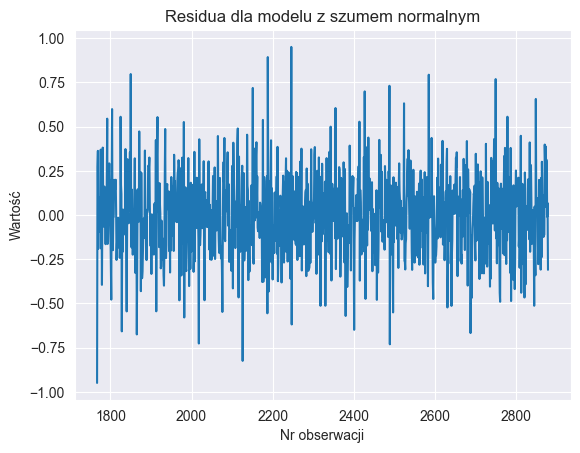

In [42]:
resid_normal =prognoza.resid
# Plot the residuals
plt.plot(resid_normal)
plt.title('Residua dla modelu z szumem normalnym')
plt.xlabel('Nr obserwacji')
plt.ylabel('Wartość')


plt.show()

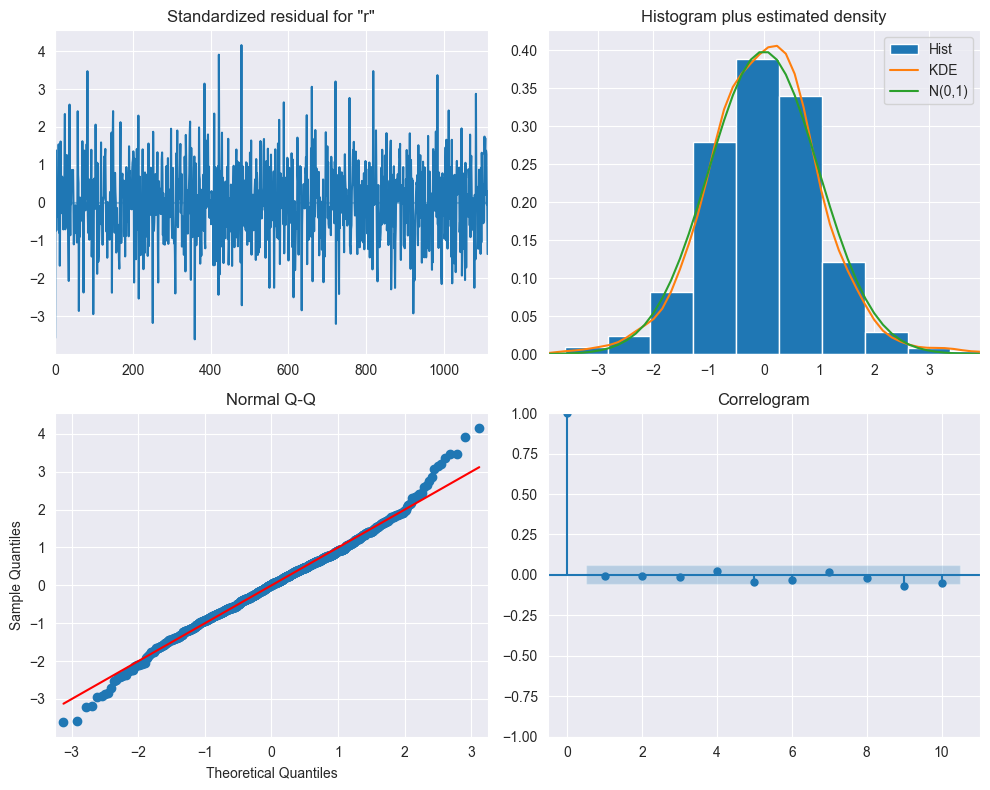

In [119]:
prognoza.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import kstest, t, gamma

Dopasowane parametry t-rozkladu: df=8.57, loc=-0.00, scale=0.20


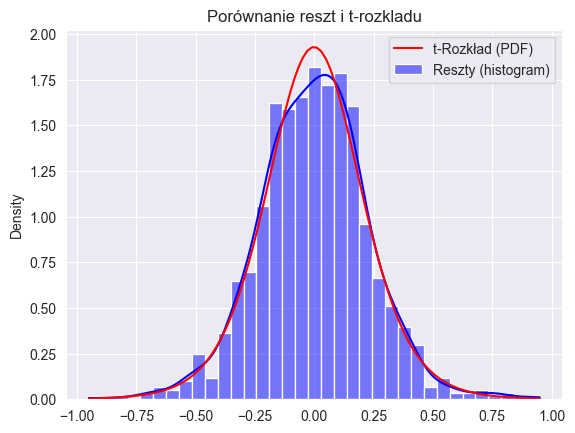

In [120]:
residuals = prognoza.resid

t_params = t.fit(residuals)
df, loc, scale = t_params

print(f"Dopasowane parametry t-rozkladu: df={df:.2f}, loc={loc:.2f}, scale={scale:.2f}")

import seaborn as sns

sns.histplot(residuals, kde=True, stat="density", label="Reszty (histogram)", color="blue")
x = np.linspace(min(residuals), max(residuals), 100)
plt.plot(x, t.pdf(x, df, loc, scale), label="t-Rozkład (PDF)", color="red")
plt.legend()
plt.title("Porównanie reszt i t-rozkladu")
plt.show()

In [121]:
ks_stat, p_value = kstest(residuals, 't', args=(df, loc, scale))

print(f"Statystyka KS: {ks_stat:.4f}")
print(f"P-wartość KS testu: {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value > alpha:
    print("Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z t-rozkladu.")
else:
    print("Odrzucamy hipotezę zerową - reszty nie pasują do t-rozkladu.")

Statystyka KS: 0.0225
P-wartość KS testu: 0.6197
Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z t-rozkladu.


In [122]:
gamma_params = gamma.fit(residuals)
shape, loc, scale = gamma_params

# Test Kolmogorova-Smirnova (KS test) dla gamma-rozkladu
ks_stat, p_value = kstest(residuals, 'gamma', args=(shape, loc, scale))

print(f"Dopasowane parametry gamma-rozkladu: shape={shape:.4f}, loc={loc:.4f}, scale={scale:.4f}")
print(f"Statystyka KS: {ks_stat:.4f}")
print(f"P-wartość KS testu: {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value > alpha:
    print("Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z gamma-rozkladu.")
else:
    print("Odrzucamy hipotezę zerową - reszty nie pasują do gamma-rozkladu.")

Dopasowane parametry gamma-rozkladu: shape=1764.4731, loc=-9.6344, scale=0.0055
Statystyka KS: 0.0312
P-wartość KS testu: 0.2228
Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z gamma-rozkladu.


In [123]:
from scipy.stats import weibull_min
weibull_params = weibull_min.fit(residuals)
shape, loc, scale = weibull_params

# Test Kolmogorova-Smirnova (KS test) dla Weibull-rozkładu
ks_stat, p_value = kstest(residuals, 'weibull_min', args=(shape, loc, scale))

print(f"Dopasowane parametry Weibull-rozkładu: shape={shape:.4f}, loc={loc:.4f}, scale={scale:.4f}")
print(f"Statystyka KS: {ks_stat:.4f}")
print(f"P-wartość KS testu: {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value > alpha:
    print("Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z Weibull-rozkładu.")
else:
    print("Odrzucamy hipotezę zerową - reszty nie pasują do Weibull-rozkładu.")

Dopasowane parametry Weibull-rozkładu: shape=3.7886, loc=-0.7994, scale=0.8825
Statystyka KS: 0.0417
P-wartość KS testu: 0.0401
Odrzucamy hipotezę zerową - reszty nie pasują do Weibull-rozkładu.


In [124]:
from scipy.stats import norm, kstest

# Dopasowanie rozkładu normalnego do reszt
normal_params = norm.fit(train_clean)
loc, scale = normal_params

# Test Kolmogorova-Smirnova (KS test) dla rozkładu normalnego
ks_stat, p_value = kstest(train_clean, 'norm', args=(loc, scale))

print(f"Dopasowane parametry rozkładu normalnego: loc={loc:.4f}, scale={scale:.4f}")
print(f"Statystyka KS: {ks_stat:.4f}")
print(f"P-wartość KS testu: {p_value:.4f}")

# Interpretacja wyniku
alpha = 0.05
if p_value > alpha:
    print("Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z rozkładu normalnego.")
else:
    print("Odrzucamy hipotezę zerową - reszty nie pasują do rozkładu normalnego.")

Dopasowane parametry rozkładu normalnego: loc=-0.0004, scale=0.2654
Statystyka KS: 0.0379
P-wartość KS testu: 0.0799
Brak podstaw do odrzucenia hipotezy zerowej - reszty mogą pochodzić z rozkładu normalnego.


In [129]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(resid_normal, lags=[int(np.sqrt(len(nowa_temperature)))], return_df=True)

,lb_stat,lb_pvalue
37,49.373687,0.08392


In [126]:
from scipy.stats import ttest_1samp
stat, p = ttest_1samp(resid_normal, popmean=0)
print(stat,p)

-0.07809733919000025 0.9377646738311822


In [127]:
from scipy.stats import shapiro

stat, p_value = shapiro(resid_normal)

# Wyniki testu
print(f"Statystyka Shapiro-Wilka: {stat}")
print(f"P-wartość: {p_value}")

# Wniosek
alpha = 0.05  # Poziom istotności
if p_value > alpha:
    print("Nie można odrzucić hipotezy zerowej: Dane mają rozkład normalny.")
else:
    print("Odrzucamy hipotezę zerową: Dane nie mają rozkładu normalnego.")

Statystyka Shapiro-Wilka: 0.9915878176689148
P-wartość: 5.588492058450356e-06
Odrzucamy hipotezę zerową: Dane nie mają rozkładu normalnego.


In [128]:
from statsmodels.stats.diagnostic import het_arch

p_value = het_arch(resid_normal)
print(p_value[1])

6.002465735398444e-05


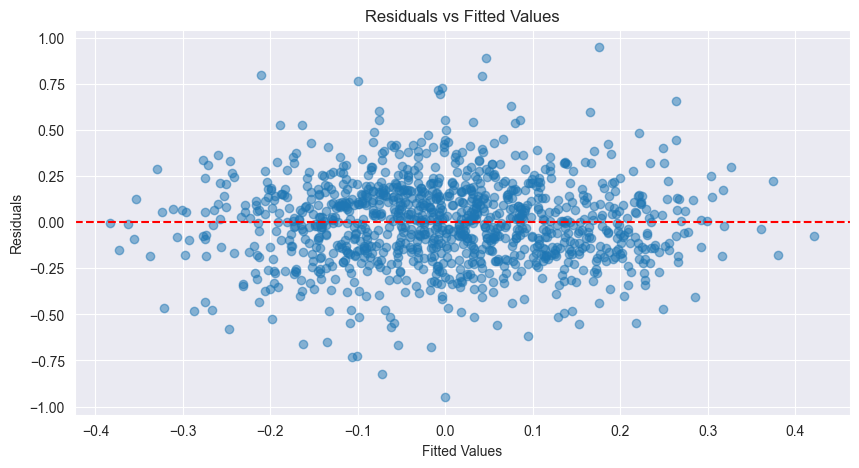

In [43]:
plt.figure(figsize=(10, 5))
plt.scatter(prognoza.fittedvalues, resid_normal, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

In [49]:
from statsmodels.stats.diagnostic import het_breuschpagan
import numpy as np
import statsmodels.api as sm

# Get residuals and fitted values
radio = prognoza.fittedvalues
exog = sm.add_constant(radio)  
print(exog)
# Perform Breusch-Pagan test
bp_test = het_breuschpagan(resid_normal, exog)

# Extract p-value
p_value = bp_test[1]

print(f"Breusch-Pagan test p-value: {p_value}")

if p_value < 0.05:
    print("Heteroskedasticity detected (residual variance is not constant).")
else:
    print("No significant heteroskedasticity detected (residual variance is constant).")


      const         0
1767    1.0  0.000001
1768    1.0 -0.128603
1769    1.0  0.079652
1770    1.0  0.193736
1771    1.0  0.177427
...     ...       ...
2875    1.0 -0.271700
2876    1.0 -0.329173
2877    1.0 -0.362249
2878    1.0 -0.300977
2879    1.0 -0.215408

[1113 rows x 2 columns]
Breusch-Pagan test p-value: 0.31507926042231693
No significant heteroskedasticity detected (residual variance is constant).


In [59]:
from scipy.stats import levene

median_resid = np.median(resid_normal)
group1 = resid_normal[resid_normal <= median_resid]  # Below or equal to median
group2 = resid_normal[resid_normal > median_resid]   # Above median


# Perform the Modified Levene Test
stat, p_value = levene(group1, group2, center='median')

# Display results
print(f"Levene Statistic: {stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: Variances are not equal (heteroscedasticity detected).")
else:
    print("Fail to reject the null hypothesis: Residuals have equal variance (homoscedasticity).")

Levene Statistic: 0.0495
P-Value: 0.8241
Fail to reject the null hypothesis: Residuals have equal variance (homoscedasticity).


In [52]:
from scipy.stats import bartlett

stat, p_value = bartlett(group1, group2)
print(f"Bartlett's test p-value: {p_value:.4f}")

Bartlett's test p-value: 0.7390


In [54]:
from statsmodels.stats.diagnostic import het_arch
# Perform ARCH test (default lag=1)
arch_test = het_arch(resid_normal)

# Extract results
LM_stat = arch_test[0]  # Lagrange Multiplier statistic
p_value = arch_test[1]  # p-value
f_stat = arch_test[2]   # F-statistic
f_p_value = arch_test[3]  # F-test p-value

# Print results
print(f"ARCH Test Results:")
print(f"Lagrange Multiplier Statistic: {LM_stat:.4f}")
print(f"LM Test p-value: {p_value:.4f}")
print(f"F-statistic: {f_stat:.4f}")
print(f"F-test p-value: {f_p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: Heteroscedasticity detected (ARCH effects present).")
else:
    print("Fail to reject the null hypothesis: No significant ARCH effects (homoscedastic residuals).")

ARCH Test Results:
Lagrange Multiplier Statistic: 36.8522
LM Test p-value: 0.0001
F-statistic: 3.7746
F-test p-value: 0.0001
Reject the null hypothesis: Heteroscedasticity detected (ARCH effects present).


In [60]:
from arch import arch_model

# Fit a GARCH(1,1) model on residuals
garch_model = arch_model(resid_normal, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp="off")

print(garch_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                65.1790
Distribution:                  Normal   AIC:                          -122.358
Method:            Maximum Likelihood   BIC:                          -102.299
                                        No. Observations:                 1113
Date:                Thu, Jan 30 2025   Df Residuals:                     1112
Time:                        23:22:36   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.0358e-03  6.971e-03      0.149      0.882 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05262. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


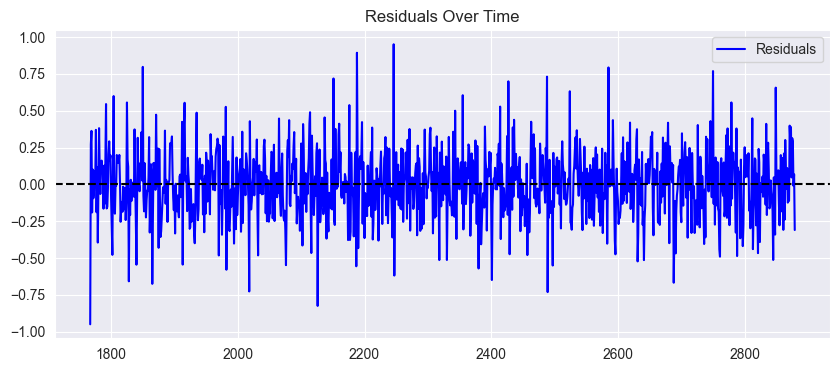

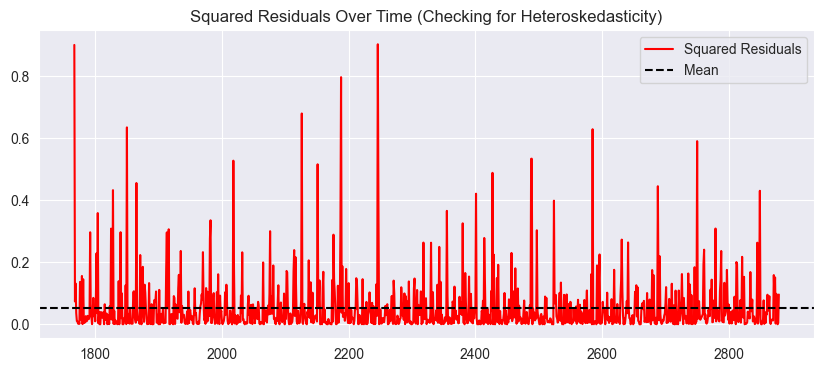

In [56]:
plt.figure(figsize=(10, 4))
plt.plot(resid_normal, label="Residuals", color="blue")
plt.axhline(y=0, color="black", linestyle="--")
plt.title("Residuals Over Time")
plt.legend()
plt.show()

# Plot squared residuals to check for volatility clustering
plt.figure(figsize=(10, 4))
plt.plot(resid_normal**2, label="Squared Residuals", color="red")
plt.axhline(y=np.mean(resid_normal**2), color="black", linestyle="--", label="Mean")
plt.title("Squared Residuals Over Time (Checking for Heteroskedasticity)")
plt.legend()
plt.show()

In [ ]:
import numpy as np
from arch import arch_model

# Przeszukiwanie siatki dla GARCH(p, q)
best_aic = np.inf
best_order = None
best_model = None

for p in range(1, 4):  # Zakres dla p
    for q in range(1, 4):  # Zakres dla q
        try:
            model = arch_model(temperature, vol='Garch', p=p, q=q, dist='t')
            results = model.fit(disp='off')
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, q)
                best_model = results
        except:
            continue

print(f"Najlepszy model: GARCH{best_order} z AIC: {best_aic}")
print(best_model.summary())

Najlepszy model: GARCH(1, 1) z AIC: 18066.98912702701
                        Constant Mean - GARCH Model Results                         
Dep. Variable:       LandAverageTemperature   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -9028.49
Distribution:      Standardized Student's t   AIC:                           18067.0
Method:                  Maximum Likelihood   BIC:                           18097.3
                                              No. Observations:                 3159
Date:                      Thu, Jan 30 2025   Df Residuals:                     3158
Time:                              17:25:44   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
-----------------------------------

In [ ]:
from arch import arch_model


model = arch_model(temperature, vol='Garch', p=1, q=3, dist='t')
results = model.fit()

# Wyświetlenie wyników dopasowania
print(results.summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: 11917.356833531627
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9947.515383052674
Iteration:      3,   Func. Count:     29,   Neg. LLF: 9326.752054730428
Iteration:      4,   Func. Count:     38,   Neg. LLF: 1009128.9796512483
Iteration:      5,   Func. Count:     47,   Neg. LLF: 10320.404268379778
Iteration:      6,   Func. Count:     56,   Neg. LLF: 9068.225082626352
Iteration:      7,   Func. Count:     64,   Neg. LLF: 9057.92583828475
Iteration:      8,   Func. Count:     72,   Neg. LLF: 9054.366413427388
Iteration:      9,   Func. Count:     80,   Neg. LLF: 9049.787088987785
Iteration:     10,   Func. Count:     88,   Neg. LLF: 9046.834131423511
Iteration:     11,   Func. Count:     96,   Neg. LLF: 9042.576655561585
Iteration:     12,   Func. Count:    104,   Neg. LLF: 9038.04140421925
Iteration:     13,   Func. Count:    112,   Neg. LLF: 9035.025158109964
Iteration:     14,   Func. Count:    120,   Neg. LLF: 9033.2429

Pytania

Czy na pewno nie wykonujemy boxa-coxa

Predykcja - dzielimy dane na treningowe wtedy 

ADF dla wyczyszczonych czy dla treningowych 

rzad modelu dla treningowych czystych

parametry dla treningowych czystych

przedzial dla treningowych czystych

kantylowe dla treningowych czystych 

prognoza - forecast na bazie treningowych na okresie testowym

analiza residuów - orginalne dane, model z treningowego dobrany 

normlanosc - gestosc, dystrybuanta, test na normlanosc

niezaleznosc - ljung box 




czy analiza dwóch modelów dobranych moze byc ok ?

